In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import riesling as rl

# Introduction
This demo will go through the basic funcionality in `riesling` using a phantom example. `riesling` will be executed as a commandline tool and basic methods for integration with python are demonstrated as well.

The following commands are available in `riesling`

In [2]:
!riesling -h

  riesling COMMAND {OPTIONS}

    RIESLING

  OPTIONS:

      COMMANDS
        admm                              ADMM recon
        blend                             Blend basis images
        cg                                cgSENSE/Iterative recon w/ Töplitz
                                          embedding
        compress                          Apply channel compression
        espirit                           Create SENSE maps with ESPIRiT
        grid                              Grid from/to non-cartesian to/from
                                          cartesian
        hdr                               Print the header from an HD5 file
        lookup                            Basis dictionary lookup
        lsqr                              Iterative recon with LSQR optimizer
        meta                              Print meta-data entries
        nii                               Convert h5 to nifti
        nufft                             Apply forward/reverse NUFF

Before we begin, it is worth cleaning the working directory of existing `.h5` files. Sometimes if there is an error while an `.h5` is open, subsequent attempts to write to that file will fail and cause havoc.

In [3]:
!rm tut*.h5

The commands will be exectued without verbose mode on here to reduce stdout output, but if you want to get a better idea of what is happening, add `-v`. If you want even more info set `--verbosity 1/2/3`, at the highest level you will get intermediate image files saved as well, such as iterations in iterative methods.

## Table of contents

- [1. Generate a phantom](#gen_phantom)
- [2. The H5 format](#h5_hdr_data_traj)
    - [2.1 Look at the raw data, header, and trajectory using riesling](#h5_riesling)
    - [2.2 Import the data into python](#h5_python)
- [3. Root sum of squares reconstruction](#rss_recon)
- [4. SENSE Reconstruction](#sense_recon)
    - [4.1 Coil compression](#coil_compress)
- [5. Iterative Reconstruction](#iterative_recon)
    - [5.1 Conjugate Gradients](#cg_sense)
    - [5.2 Total Generalised Variation](#tgv)
- [6. Gridding methods](#gridding_methods)



<a href='gen_phantom'></a>
## 1. Generate a Phantom

We start by generating a 3D Shepp Logan phantom which will be used for this demonstration. We use a 

- `mat`: Matrix size of 128 which results in a nominal number of spokes $N_{nom} = MAT^2\cdot \pi=51471$. In `riesling` we assume a factor of $\pi$ undersampling is fully sampled. We therefore ignore this factor. 
- `srate`: We undersample in the angular direction by $\pi$ and an additional 25%.
- `lrate`: Scale factor for gradient amplitude in low-resolution spokes for filling deadtime gap. Will also set the number of low-res spokes.
- `snr`: SNR of 50
- `gap`: Dead-time gap of 3


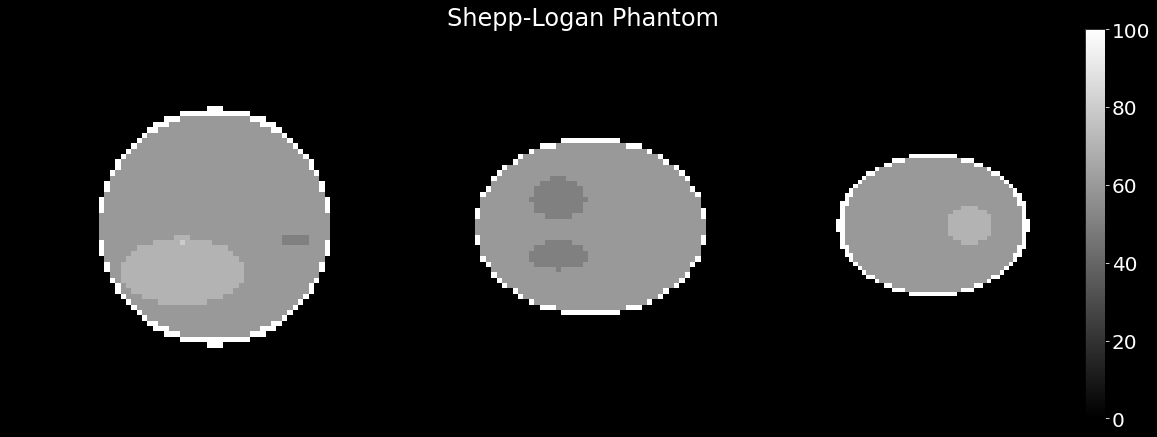

In [4]:
mat=64
snr = 50
nchan = 4
!riesling phantom tut --shepp_logan --matrix={mat} --snr={snr} --channels={nchan}
display(rl.images.planes('tut.h5', dset='phantom', title='Shepp-Logan Phantom', clim=[0,100]))

**Note!** `riesling` utilise the FFTW library to calculate FFTs. FFTW uses a planner function to optimise the FFT calculation for your system and different data structures. The first time you calculate a new FFT you will therefore notice a longer computational time. The next time it will be a lot faster! You can force `riesling` to do this explicitly with the `plan` command. You only need to do this once for a particular trajectory.

We now have a file called `tut.h5` which contains the radial k-space data, the header information, and the trajectory. To do a simple reconstruction we use the `recon` command with the `--rss` (root-sum-squares) option.

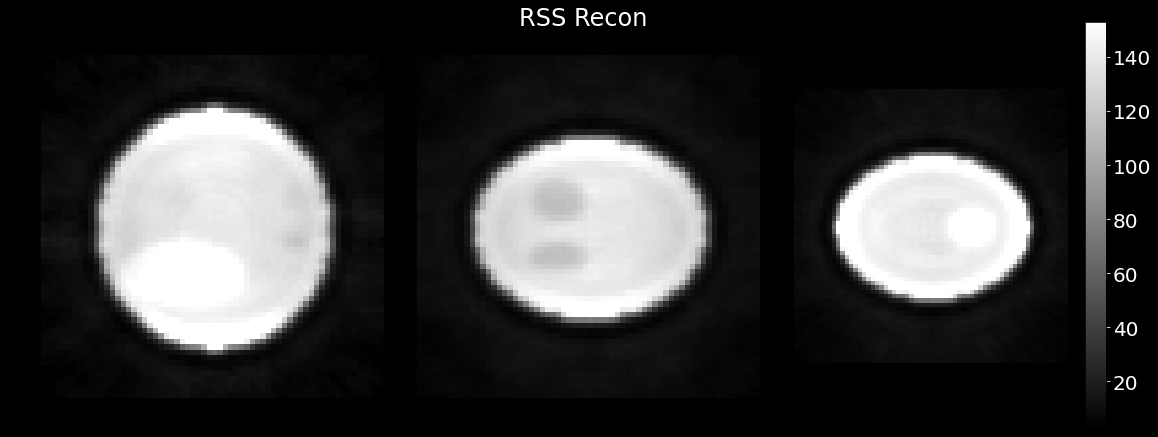

In [5]:
!riesling recon --rss tut.h5
rl.images.planes('tut-recon.h5', title='RSS Recon')

<a href='h5_hdr_data_traj'></a>
## 2. H5 format - Header, Data, Trajectory
The `.h5` format used in `riesling` is a simple data structure containing the radial k-space data, trajectory and meta data. Below we demonstrate how to look at the data structure using `riesling` and then with python.


<a href='h5_riesling'></a>
### 2.1 Using `riesling`
You can inspect the `h5` file using the `hdr` command

In [6]:
!riesling hdr tut.h5

Type: 3D
Matrix: 64 64 64
Channels: 4 Read points: 64 Spokes: 4096
Volumes: 1 Echoes: 1
Voxel-size: 3.75 3.75 3.75	 TR: 1	 Origin: -120 -120 -120
Direction:
1 0 0
0 1 0
0 0 1


The `traj` command can be used to grid your data for inspection and also calculate the point spread function. The trajectory will be weighted by the number of samples at each Cartesian grid-point. The slice through the equator k-space has few samples on the left-hand side due to specific Archimedean spiral used for the trajectory. For a similar reason, the point-spread function shows some aliasing in the polar directions. 

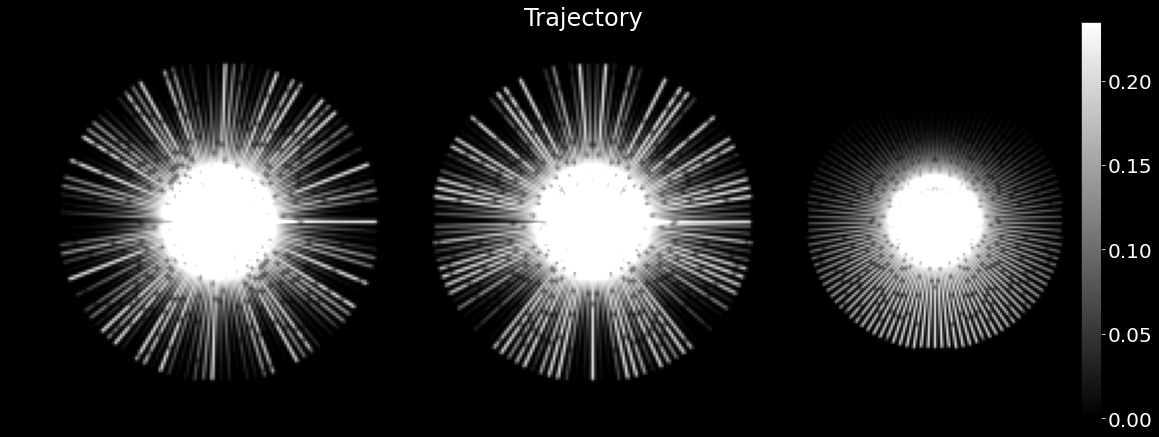

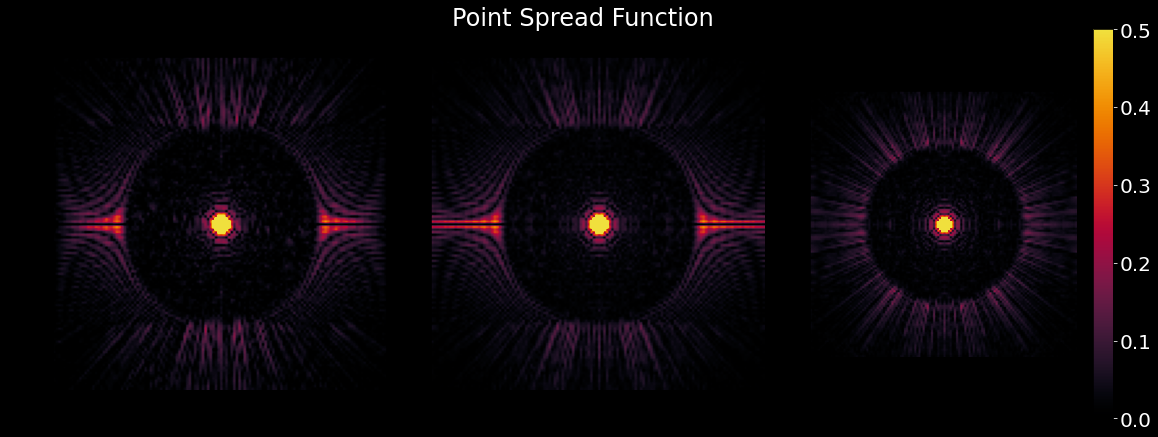

In [7]:
!riesling traj --psf tut.h5
display(rl.images.planes('tut-traj.h5', title='Trajectory', dset='traj-image'))
display(rl.images.planes('tut-traj.h5', title='Point Spread Function', dset='psf-image', comp='log', cmap='cmr.ember', clim=(0,0.5)))

<a href='sdc'></a>
### 2.2 Saving Sample Densities
Density Compensation is very important for fast 3D reconstructions. The [Pipe and Menon](https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1522-2594(199901)41:1%3C179::AID-MRM25%3E3.0.CO;2-V) method, with an adaption using nearest-neighbour gridding for speed, is used by default in `riesling`.

Sample densities are constant for any given trajectory. Hence `riesling` allows you to calculate them once and then re-use them, with the `sdc` command. We will now do this and use the saved densities for the remaining reconstructions. The output filename will be `input-sdc.h5` and can be loaded with `--sdc=input-sdc.h5`. You can specify `--sdc=pipe` to use the more accurate but slower full Pipe-Menon method.

There is a separate notebook (`sdc.ipynb`) to illustrate how important SDC is for 3D radial trajectories.

In [8]:
!riesling sdc --sdc=pipenn tut.h5

<a id='h5_python'></a>
### 2.3 Read radial h5 file into python
In some cases you might want to look at the raw data yourself in python for debugging or to do other recon. Since we use a standard HDF5 file it is easy to read in the data using the `h5py` library. The `info` structure is a numpy array where each entry has a special datatype with an associated name and data format. You can access elements using the names like a dictionary. The trajectory is a numpy array with order [spokes, readout, dimension]. The data is stored such that, if you like to, you can access it through hyperslabs. Here we read in all of it at once. It has the shape of [volumes, spokes, readout, coils].

It is good practice to open an h5 file in a `with:` block. `hypy` will keep files open on disk until the `File` object goes out of scope, which will prevent the files being overwritten.

In [9]:
import h5py
with h5py.File("tut.h5",'r') as f:
    print(f.keys())
    info = f['info'][:]
    for k in info.dtype.names:
        print("{}: {}".format(k, info[k]))
    trajectory = f['trajectory'][:]
    print("Trajectory shape: {}".format(trajectory.shape))
    data = f['noncartesian'][:]
    print("Data shape: {}".format(data.shape))

<KeysViewHDF5 ['echoes', 'info', 'noncartesian', 'phantom', 'trajectory']>
matrix: [[64 64 64]]
voxel_size: [[3.75 3.75 3.75]]
read_points: [64]
spokes: [4096]
channels: [4]
type: [1]
volumes: [1]
echoes: [1]
tr: [1.]
origin: [[-120. -120. -120.]]
direction: [[1. 0. 0. 0. 1. 0. 0. 0. 1.]]
Trajectory shape: (4096, 64, 3)
Data shape: (1, 4096, 64, 4)


Let's have a look at the trajectory, and the data both in non-cartesian space and on the cartesian grid.

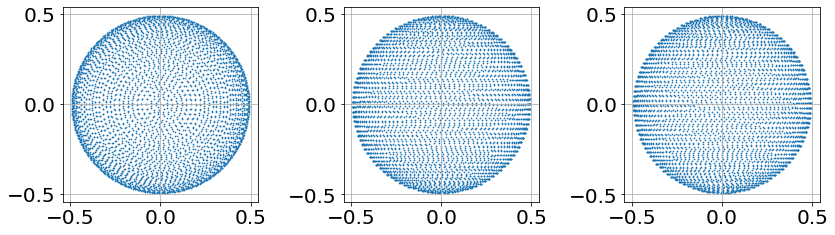

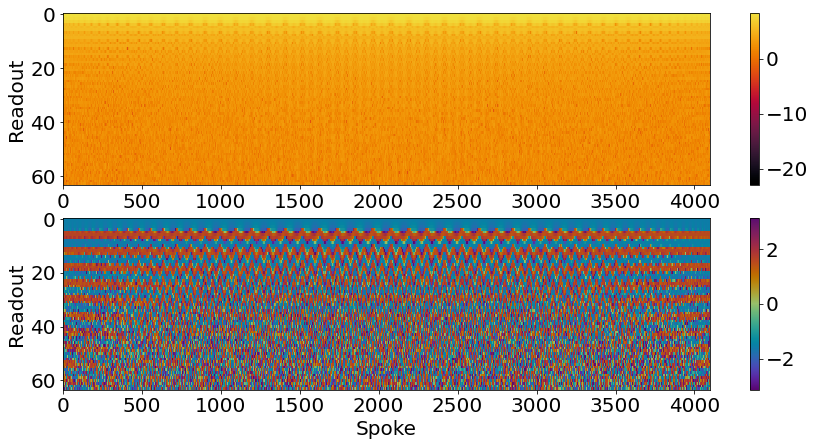

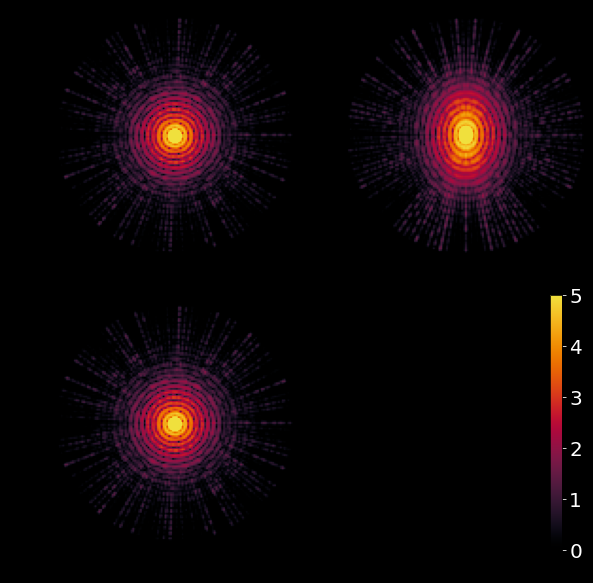

In [10]:
display(rl.plots.traj2d('tut.h5', sl_read=-1))
display(rl.plots.kspace('tut.h5',sl_spoke=slice(0,4096),coil=0))
!riesling grid tut.h5 --sdc=tut-sdc.h5 --kernel=KB3
display(rl.images.grid('tut-grid.h5', dset='cartesian', clim=(0, 5), ic=0))

<a id='sense_recon'></a>
## 3. SENSE Reconstruction
Above we did a simple RSS reconstruction. The next step is to do a SENSE reconstruction where we estimate coil sensitivity maps and do a complex coil combination. This allows us to reconstruct the phase of the image, and can reduce receive coil intensity inhomogeneities (bias field). The `recon` command automatically estimate sensitivities if you do not specify the `--rss` option using the method of [Yeh et al](http://doi.wiley.com/10.1002/mrm.20517). However, if you want to see the sensitivities, or will be applying the same sensitivities to multiple images, then you can use the `sense-calib` command first to save them.

By default, the sensitivites are calculated at an isotropic FOV of 256 mm to match the cropping volume used during iterative reconstruction.

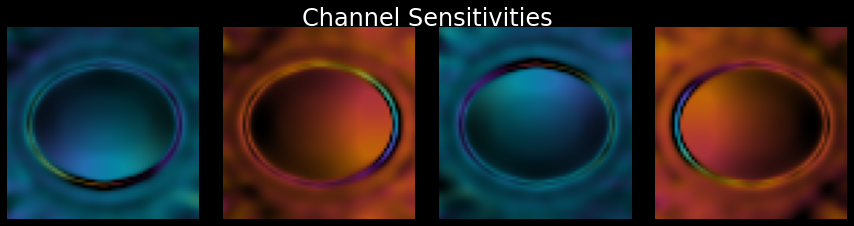

In [11]:
!riesling sense-calib --sdc=tut-sdc.h5 tut.h5
rl.images.sense('tut-sense.h5', title='Channel Sensitivities')

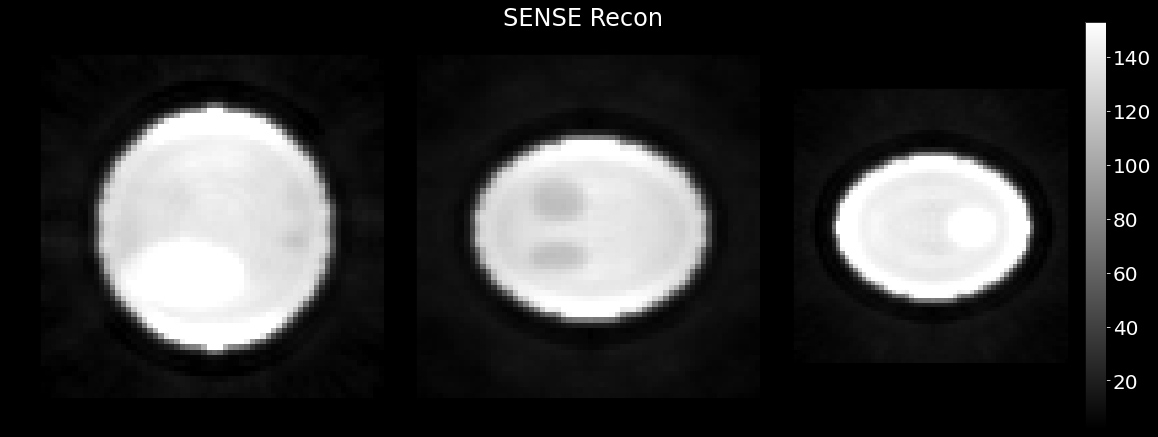

In [12]:
!riesling recon --sense=tut-sense.h5 --sdc=tut-sdc.h5 tut.h5
display(rl.images.planes('tut-recon.h5', title='SENSE Recon'))

<a id='iterative_recon'></a>
## 5. Iterative Reconstruction
Iterative reconstructions use the inverse problem framework - instead of starting from k-space data and applying a series of operations to reconstruct an image, we start by asking the question "What is the image that best explains the acquired k-space data?". There are a large number of iterative reconstruction methods, two are presented below.

<a id='cg_sense'></a>
### 5.1 Conjugate Gradients - CG-SENSE
CG-SENSE is the gold standard iterative reconstruction method and was recently highlighted in the [2020 Reproducibility Studygroup reconstruction challenge](https://onlinelibrary.wiley.com/doi/10.1002/mrm.28569). CG-SENSE will use the redundant information from a multi-channel coil to fill in missing sections of k-space and hence produce a sharper image. However running for too many iterations may produce a noisy image or aliasing artefacts.

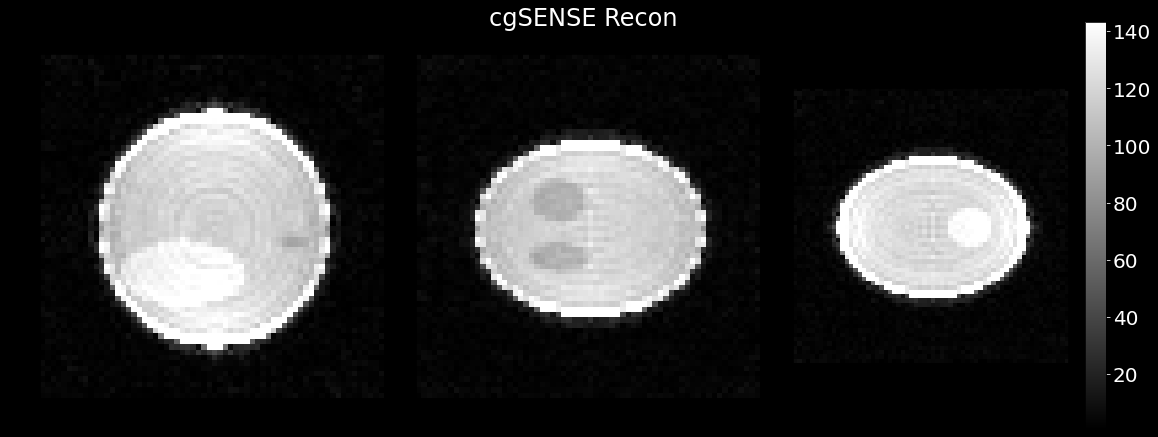

In [13]:
!riesling cg tut.h5 --sense=tut-sense.h5 --sdc=tut-sdc.h5 --cg_its=4
rl.images.planes('tut-cg.h5', title='cgSENSE Recon')

<a id='tgv'></a>
### 5.2 TGV

TGV is a powerful regularisation method which models the image as piece-wise linear. The key extra argument is `--alpha` which controls the amount of regularisation. The default value is $10^{-5}$, a value of $2\times10^{-5}$ often works well. Better image quality will be obtained with a higher number of iterations than CG.

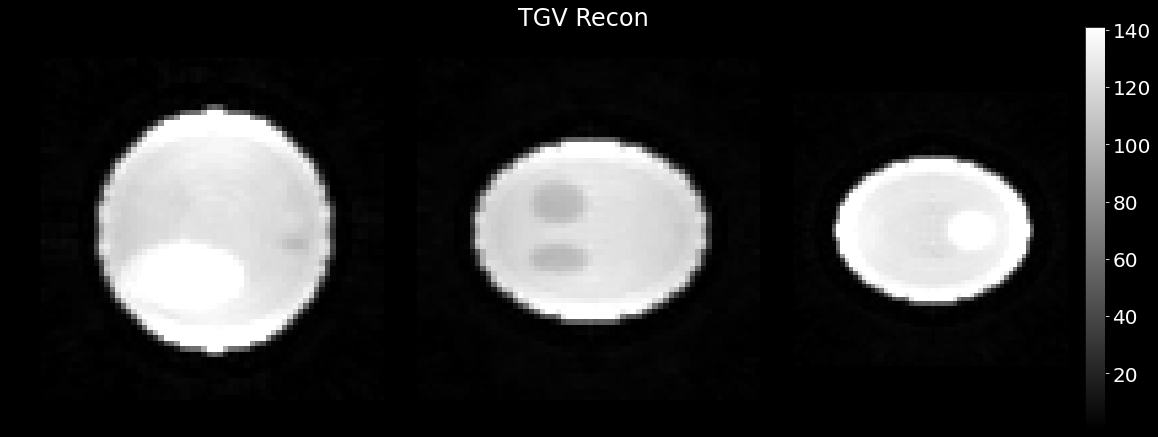

In [14]:
!riesling tgv tut.h5 --sense=tut-sense.h5 --sdc=tut-sdc.h5 --alpha 2E-5 --max_its=10
rl.images.planes('tut-tgv.h5', title='TGV Recon')